## Python Version 3.10.10

In [ ]:
# !pip install opencv-python==4.8.0
# !pip install numpy==1.21.5
# !pip install scikit_learn==1.3.0
# !pip install matplotlib==3.7.2
# !pip install tensorflow==2.13.0

## Import TensorFlow and other libraries

In [ ]:
import os
import pathlib
import time
import datetime

import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython import display

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
shadow_path = '/content/drive/MyDrive/Projects/shadow_remover/dataset/train_custom/train_custom_A/109-6.png' # One shadow image for visulizing
no_shadow_path = '/content/drive/MyDrive/Projects/shadow_remover/dataset/train_custom/train_custom_C/109-6.png' # One non-shadow image for visulizing

train_path = '/content/drive/MyDrive/Projects/shadow_remover/dataset/train' # train path for first stage.
test_path = '/content/drive/MyDrive/Projects/shadow_remover/dataset/test' # test path for first stage.

custom_train = '/content/drive/MyDrive/Projects/shadow_remover/dataset/train_custom' # train path for second stage or training on custom data
custom_test = '/content/drive/MyDrive/Projects/shadow_remover/dataset/test_custom' # test path for second stage or testing on custom data

checkpoint_dir = '/content/drive/MyDrive/Projects/shadow_remover/freez_layers_checkpoints' # path where we can save weights
log_dir="/content/drive/MyDrive/Projects/shadow_remover/logs/" # path to save training logs

input_video_path = '/content/drive/MyDrive/Projects/shadow_remover/shadow_input.mp4' # path used to get the input video for prediction
output_video_path = '/content/drive/MyDrive/Projects/shadow_remover/freezed_layer/freez_output.mp4' # path used to store the output video prediction

### Helper Functions

In [ ]:
def load(shadow_path, non_shadow_path):
    # Read and decode an image file to a uint8 tensor
    load_img(shadow_path, target_size=(256, 256))
    shadow_image = tf.io.read_file(shadow_path)
    shadow_image = tf.io.decode_png(shadow_image)
    non_shadow_image = tf.io.read_file(non_shadow_path)
    non_shadow_image = tf.io.decode_png(non_shadow_image)

    # Convert both images to float32 tensors
    shadow_image = tf.cast(shadow_image, tf.float32)
    non_shadow_image = tf.cast(non_shadow_image, tf.float32)

    return shadow_image, non_shadow_image



### Test Helper function
- Assuming that there are images in the `./train/train_A/` and `./train/train_C/` directory

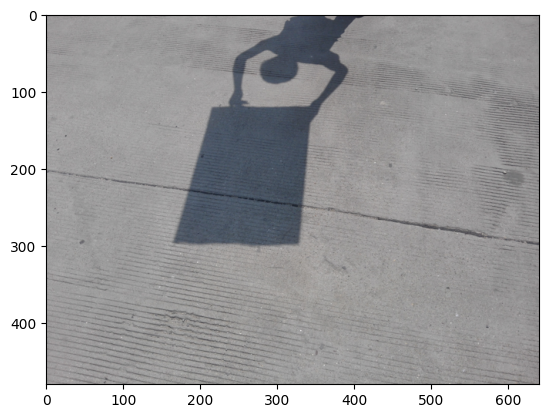

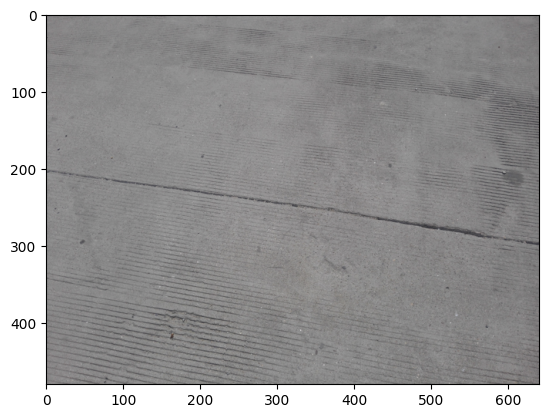

In [ ]:
inp, re = load(shadow_path, no_shadow_path)
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

### Global Variables

In [ ]:
# BUFFER_SIZE should match training set size
BUFFER_SIZE = 612
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

# LAMBDA for generator loss
LAMBDA = 100

# Output Channel For generator
OUTPUT_CHANNELS = 3

### Helper preprocessing function

In [ ]:
def resize(shadow_img, no_shadow_img, height, width):
    shadow_img = tf.image.resize(shadow_img, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    no_shadow_img = tf.image.resize(no_shadow_img, [height, width],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return shadow_img, no_shadow_img

In [ ]:
# Normalizing the images to [-1, 1]
def normalize(shadow_img, no_shadow_img):
    shadow_img = (shadow_img / 127.5) - 1
    no_shadow_img = (no_shadow_img / 127.5) - 1

    return shadow_img, no_shadow_img

In [ ]:
def random_crop(shadow_img, no_shadow_img):
    stacked_image = tf.stack([shadow_img, no_shadow_img], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [ ]:
@tf.function()
def random_jitter(shadow_img, no_shaow_img):
    # Resizing to 286x286
    shadow_img, no_shaow_img = resize(shadow_img, no_shaow_img, 286, 286)

    # Random cropping back to 256x256
    shadow_img, no_shaow_img = random_crop(shadow_img, no_shaow_img)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        shadow_img = tf.image.flip_left_right(shadow_img)
        no_shaow_img = tf.image.flip_left_right(no_shaow_img)

    return shadow_img, no_shaow_img

### Test Preprocessing Functions

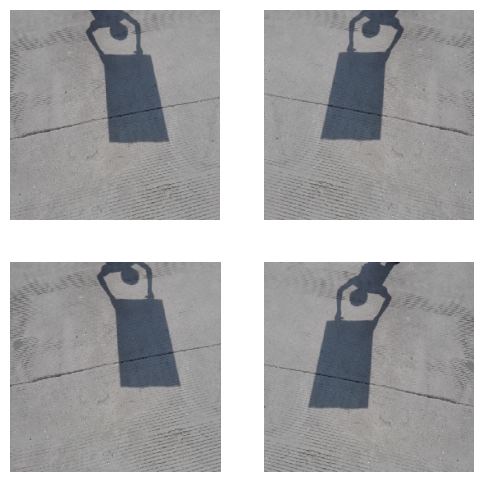

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()

### Data Augmentation Function

In [ ]:
def empty_generator():
    for _ in []:
        yield None

In [ ]:
def apply_augmentation(shadowed_img, non_shadowed_img):

    input_images = []
    target_images = []

    # Apply random cropping
    crop_input, crop_target = random_crop(shadowed_img, non_shadowed_img)

    input_images.append(crop_input)
    target_images.append(crop_target)
    # Apply random cropping
    input_images.append(random_jitter(shadowed_img, non_shadowed_img)[0])
    target_images.append(random_jitter(shadowed_img, non_shadowed_img)[1])

    # Append original images
    shadowed_img, non_shadowed_img = normalize(shadowed_img, non_shadowed_img)
    input_images.append(shadowed_img)
    target_images.append(non_shadowed_img)

    # Random mirroring
    if tf.random.uniform(()) > 0.5:
        input_images.append(tf.image.flip_left_right(shadowed_img))
        target_images.append(tf.image.flip_left_right(non_shadowed_img))

    # # Rotate 90 degrees
    # input_images.append(tf.image.rot90(shadowed_img, k=1))
    # target_images.append(tf.image.rot90(non_shadowed_img, k=1))

    # Rotate 270 degrees
    input_images.append(tf.image.rot90(shadowed_img, k=3))
    target_images.append(tf.image.rot90(non_shadowed_img, k=3))


    return tf.data.Dataset.from_tensor_slices((input_images, target_images))

### Load the dataset and apply augmentation

In [ ]:
def load_image_dataset(data_dir, augment=False):
    folder_name = os.path.basename(data_dir)

    shadowed_images_dir = os.path.join(data_dir, f'{folder_name}_A')
    non_shadowed_images_dir = os.path.join(data_dir, f'{folder_name}_C')

    shadowed_image_files = os.listdir(shadowed_images_dir)
    dataset = tf.data.Dataset.from_generator(empty_generator,
                                        output_signature=(tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                                                          tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32)))
    for filename in shadowed_image_files:

        input_images = []
        target_images = []
        shadowed_image_path = os.path.join(shadowed_images_dir, filename)
        non_shadowed_image_path = os.path.join(non_shadowed_images_dir, filename)

        shadowed_img, non_shadowed_img = load(shadowed_image_path, non_shadowed_image_path)
        shadowed_img, non_shadowed_img = resize(shadowed_img, non_shadowed_img, IMG_HEIGHT, IMG_WIDTH)

        if augment:
            augmented_dataset = apply_augmentation(shadowed_img, non_shadowed_img)
            dataset = dataset.concatenate(augmented_dataset)

        else:
            shadowed_img, non_shadowed_img = normalize(shadowed_img, non_shadowed_img)
            input_images.append(shadowed_img)
            target_images.append(non_shadowed_img)

            data_chunk = tf.data.Dataset.from_tensor_slices((input_images, target_images))
            dataset = dataset.concatenate(data_chunk)


    return dataset

### Build an input pipeline with `tf.data`
The below code should load IST Data.

In [ ]:
# # train_dataset
train_dataset = load_image_dataset(train_path)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

# # Test Data

test_dataset = load_image_dataset(test_path)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Build the generator

In [ ]:
def create_downsample_layer(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [ ]:
down_model = create_downsample_layer(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 240, 320, 3)


In [ ]:
def create_upsample_layer(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [ ]:
up_model = create_upsample_layer(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 480, 640, 3)


### Generator with the downsampler and the upsampler

In [ ]:
def create_generator_model():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        create_downsample_layer(64, 4, apply_batchnorm=False),
        create_downsample_layer(128, 4),
        create_downsample_layer(256, 4),
        create_downsample_layer(512, 4),
        create_downsample_layer(512, 4),
        create_downsample_layer(512, 4),
        create_downsample_layer(512, 4),
        create_downsample_layer(512, 4),
  ]

    up_stack = [
        create_upsample_layer(512, 4, apply_dropout=True),
        create_upsample_layer(512, 4, apply_dropout=True),
        create_upsample_layer(512, 4, apply_dropout=True),
        create_upsample_layer(512, 4),
        create_upsample_layer(256, 4),
        create_upsample_layer(128, 4),
        create_upsample_layer(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### Visualize Generator

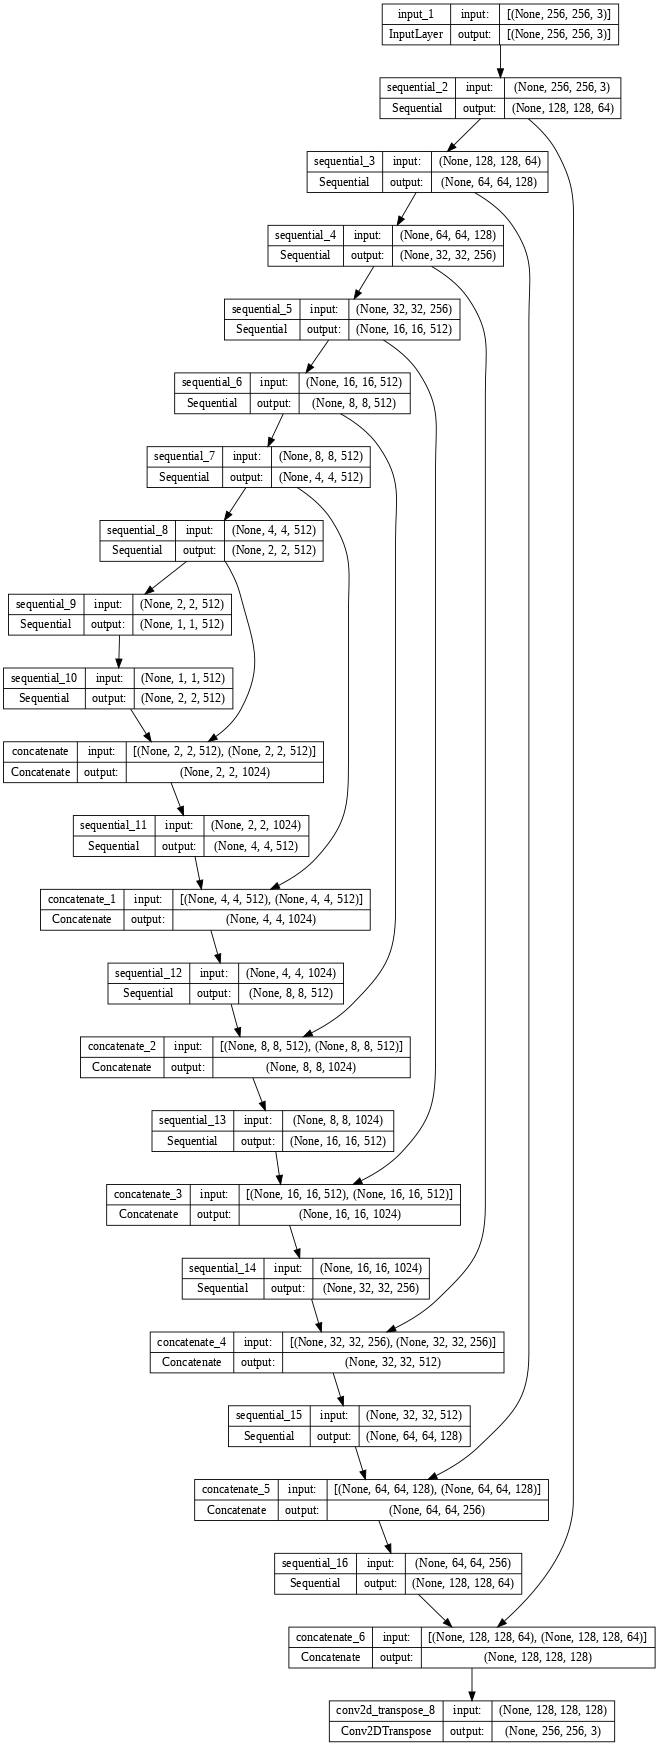

In [ ]:
generator = create_generator_model()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

### Random Test Generator

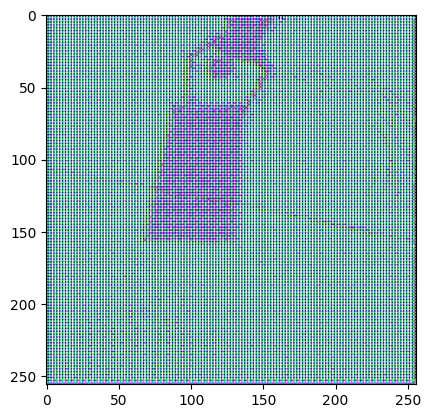

In [ ]:
inp = tf.image.resize(inp, [IMG_HEIGHT, IMG_WIDTH])
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### Generator Loss

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

### Discriminator Code

In [ ]:
def create_discriminator_model():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])

    down1 = create_downsample_layer(64, 4, False)(x)
    down2 = create_downsample_layer(128, 4)(down1)
    down3 = create_downsample_layer(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

### Visualize the discriminator model architecture

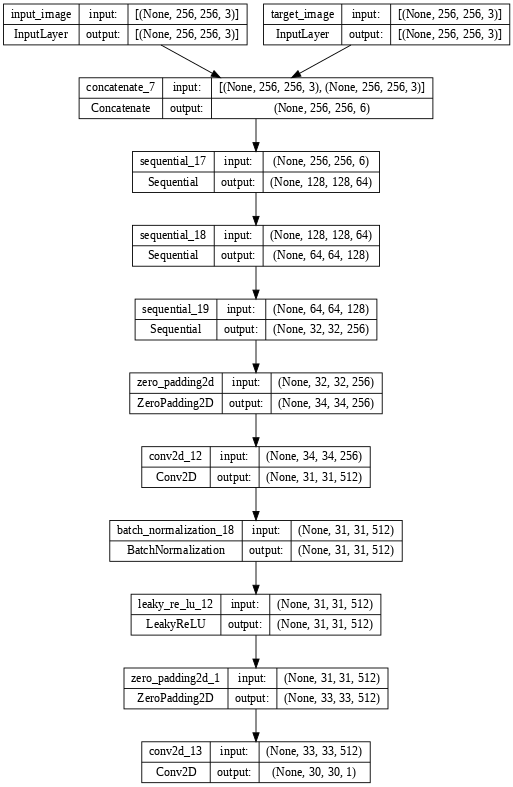

In [ ]:
discriminator = create_discriminator_model()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

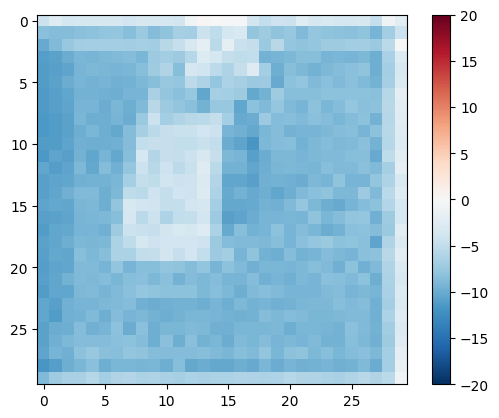

In [ ]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### Discriminator loss

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### Define the optimizers and a checkpoint-saver

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Function to Generate images

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], prediction[0], tar[0]]
    title = ['Input Image', 'Predicted Image', 'Ground Truth']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

### Test The function

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training

In [ ]:
summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

    return gen_gan_loss

In [ ]:
def fit(train_ds, test_ds, steps):

  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  best_performance = float('inf')  # Initialize with a large value
  best_model_path = None

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    gen_loss = train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

    # Save (checkpoint) the model every 1k steps and above 5k
    # if (gen_loss < best_performance) and ((step + 1) % 5000 == 0):
    if (gen_loss < best_performance) and ((step + 1) >= 5000) and ((step + 1) % 1000 == 0):
      best_performance = gen_loss
      best_model_path = checkpoint.save(file_prefix=checkpoint_prefix)
      print(f"Saved model on step {(step+1)} best model path {best_model_path}")

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

## Training on ISTD for 40k steps

Time taken for 1000 steps: 91.06 sec



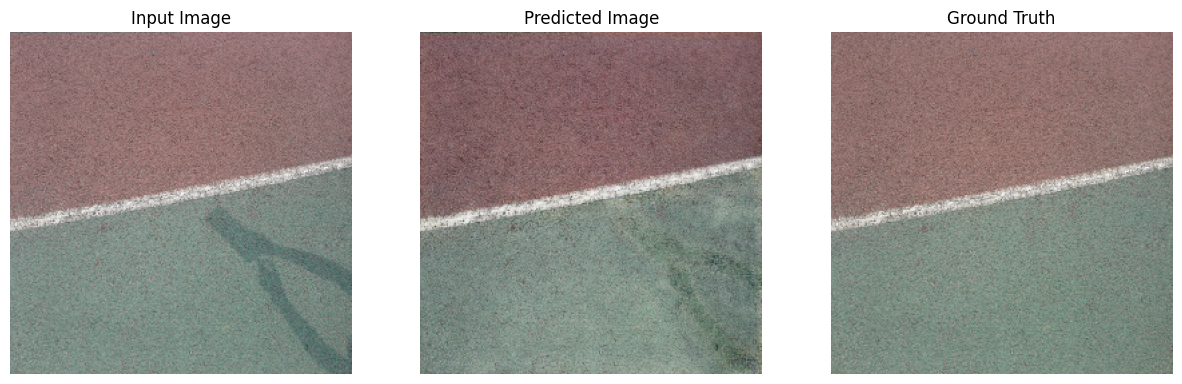

Step: 39k
....................................................................................................

In [ ]:
fit(train_dataset, test_dataset, steps=40000)

### Restore the latest checkpoint and test the model

In [ ]:
!ls {checkpoint_dir}

checkpoint		    ckpt-3.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-3.index
ckpt-1.index		    ckpt-4.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-4.index
ckpt-2.index


In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)

## Prediction on a video

In [ ]:
def predict_frame(frame, generator):
    # Preprocess the frame
    frame_processed = (frame / 127.5) - 1
    frame_processed = tf.image.resize(frame_processed, [256, 256])  # Resize to model input size
    frame_processed = tf.expand_dims(frame_processed, axis=0)  # Add batch dimension

    # Generate the prediction
    prediction = generator(frame_processed, training=True)[0]
    prediction = prediction * 0.5 + 0.5
    # Convert the prediction to uint8 format (0-255)
    prediction = (prediction.numpy() * 255).astype(np.uint8)
    return prediction

# Function to process a video
def process_video(input_path, output_path, generator):
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Double the width for horizontal stitching
    output_width = 256 * 2
    out = cv2.VideoWriter(output_path,
                         cv2.VideoWriter_fourcc(*'mp4v'),
                         fps, (output_width, 256))

    ret = True
    while ret:
        ret, frame = cap.read()

        if ret:
            # Calculate the aspect ratio of the input frame
            input_aspect_ratio = frame_width / frame_height

            # Calculate the target width and height for a 4:3 aspect ratio
            target_height = 256
            target_width = int(target_height * 4 / 3)

            if input_aspect_ratio > 4 / 3:
                # Landscape mode, crop the sides
                new_width = int(frame_height * 4 / 3)
                frame = cv2.resize(frame, (new_width, frame_height))
                start = (new_width - target_width) // 2
                frame = frame[:, start:start+target_width]
            else:
                # Portrait mode, crop the top and bottom
                new_height = int(frame_width * 3 / 4)
                frame = cv2.resize(frame, (frame_width, new_height))
                start = (new_height - target_height) // 2
                frame = frame[start:start+target_height, :]

            # Resize the frame to (256, 256) without distortion
            frame = cv2.resize(frame, (256, 256))

            # Convert the input frame from BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            prediction = predict_frame(frame_rgb, generator)

            # Create a horizontal stack of the input and output frames
            horizontal_stack = np.hstack((frame_rgb, prediction))

            # Convert the horizontal stack back to BGR before writing
            out.write(cv2.cvtColor(horizontal_stack, cv2.COLOR_RGB2BGR))

    cap.release()
    out.release()

In [ ]:
# process_video(input_video_path, output_video_path, generator)

# Step 2

We need to apply augmentation on the training set of our own dataset, as the samples are small.

Do not apply augmentation on the testing data.

In [ ]:
# Check the number of layers in the generator
num_generator_layers = len(generator.layers)
print(f"Number of layers in the generator: {num_generator_layers}")

# Check the number of layers in the discriminator
num_discriminator_layers = len(discriminator.layers)
print(f"Number of layers in the discriminator: {num_discriminator_layers}")

Number of layers in the generator: 24
Number of layers in the discriminator: 12


In [ ]:
# Freeze all layers except the last few layers
generator_unfrozen_layers = 4
discriminator_unfrozen_layers = 2

for layer in generator.layers[2:-generator_unfrozen_layers]:
    layer.trainable = False

for layer in discriminator.layers[2:-discriminator_unfrozen_layers]:
    layer.trainable = False

In [ ]:
train_dataset_custom = load_image_dataset(custom_train, augment=True)
train_dataset_custom = train_dataset_custom.shuffle(BUFFER_SIZE)
train_dataset_custom = train_dataset_custom.batch(BATCH_SIZE)

test_dataset_custom = load_image_dataset(custom_test)
test_dataset_custom = test_dataset_custom.batch(BATCH_SIZE)

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir {log_dir}

# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

Time taken for 1000 steps: 37.62 sec



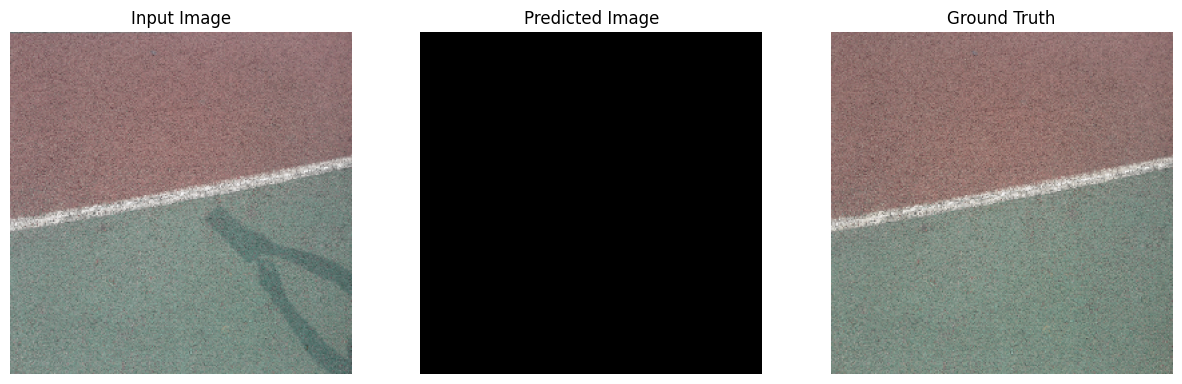

Step: 39k
....................................................................................................

In [ ]:
fit(train_dataset_custom, test_dataset_custom, steps=40000)

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
# checkpoint.save(file_prefix=checkpoint_prefix)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset_custom.take(5):
    generate_images(generator, inp, tar)

In [ ]:
%time process_video(input_video_path, output_video_path, generator)

CPU times: user 17 s, sys: 361 ms, total: 17.4 s
Wall time: 16.6 s
